# Consensus Clustering using Louvain

In this notebook we run consensus clustering by constructing an allegiance matrix from many runs of Louvain.

In [2]:
import numpy as np
import pandas as pd
import bct
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns # Using seaborn for prettier plotting
import plotly.graph_objects as go
from plotly.colors import qualitative

In [3]:
df_average = pd.read_csv('../data/average_connectome_data.csv', header=0, index_col=0)

In [56]:
# filter the afferent / efferent based on hippocampal connections, create similarity matrix
hippocampal_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd'])

# FROM hippocampus (efferent)
df_avg_from = df_average[df_average.index.isin(hippocampal_regions)]

# TO hippocampus (afferent)
df_average_t = df_average.T
df_avg_to = df_average_t[df_average_t.index.isin(hippocampal_regions)]

# drop HPC columns
df_avg_from = df_avg_from.drop(hippocampal_regions, axis=1)
df_avg_to = df_avg_to.drop(hippocampal_regions, axis=1)

# filter to only include columns and rows with at least one connection
df_avg_from = df_avg_from.loc[:,df_avg_from.apply(np.count_nonzero, axis=0) >= 1]
df_avg_to = df_avg_to.loc[:,df_avg_to.apply(np.count_nonzero, axis=0) >= 1]

# find the shared regions
common_cols = df_avg_to.columns.intersection(df_avg_from.columns)
df_avg_to_shared = df_avg_to[common_cols]
df_avg_from_shared = df_avg_from[common_cols]

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_from_values = cosine_similarity(df_avg_from.T)
cosine_from_labels = df_avg_from.columns

cosine_df_from = pd.DataFrame(cosine_from_values, 
                             index=df_avg_from.columns, 
                             columns=df_avg_from.columns)

cosine_to_values = cosine_similarity(df_avg_to.T)
cosine_to_labels = df_avg_to.columns

cosine_df_to = pd.DataFrame(cosine_to_values, 
                             index=df_avg_to.columns, 
                             columns=df_avg_to.columns)

# ---- repeat but for shared regions -----
cosine_from_shared_values = cosine_similarity(df_avg_from_shared.T)
cosine_from_shared_labels = df_avg_from_shared.columns

cosine_df_from_shared = pd.DataFrame(cosine_from_shared_values, 
                             index=df_avg_from_shared.columns, 
                             columns=df_avg_from_shared.columns)

cosine_to_shared_values = cosine_similarity(df_avg_to_shared.T)
cosine_to_shared_labels = df_avg_to_shared.columns

cosine_df_to_shared = pd.DataFrame(cosine_to_shared_values, 
                             index=df_avg_to_shared.columns, 
                             columns=df_avg_to_shared.columns)

In [45]:
# ---- compute correlation matrices ----
# probably want to drop na columns and rows of all NaNs
spearman_df_from = (df_avg_from.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
spearman_df_to = (df_avg_to.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

# ---- create thresholded matrices ----
spearman_df_from_zero_thresh = spearman_df_from.copy()
spearman_df_to_zero_thresh = spearman_df_to.copy()

# we have to set all negative values to 0, because Louvain algirithm can't handle negatives. 
spearman_df_from_zero_thresh[spearman_df_from_zero_thresh<0]=0
spearman_df_to_zero_thresh[spearman_df_to_zero_thresh<0]=0


# ---- Create data and labels for both afferent and efferent -----
# signed
signed_efferent_connection_values = spearman_df_from.values
signed_efferent_labels = spearman_df_from.index

signed_afferent_connection_values = spearman_df_to.values
signed_afferent_labels = spearman_df_to.index

# unsigned
efferent_connection_values = spearman_df_from_zero_thresh.values
efferent_labels = spearman_df_from_zero_thresh.index

afferent_connection_values = spearman_df_to_zero_thresh.values
afferent_labels = spearman_df_to_zero_thresh.index

In [46]:
import numpy as np
import bct
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import normalized_mutual_info_score

def build_allegiance_dict_signed(similarity_matrix):
    # --- 1. Define Consensus Clustering Parameters ---
    # As you requested: iterate gamma by 0.1
    gamma_range = np.arange(0.2, 5, 0.1)  # Example range: 0.5 to 2.0
    n_runs = 100
    
    # Dictionary to store the final allegiance matrix for each gamma
    all_allegiance_matrices = {}

    # Store the average stability score for each gamma
    stability_scores = {}

    n_nodes = len(similarity_matrix)
    
    print(f"Starting consensus clustering for {len(gamma_range)} gamma values ({n_runs} runs each)...")
    
    # --- 2. Run the Multiresolution Consensus Clustering ---
    for gamma in gamma_range:
        # Initialize the N x N allegiance matrix for this gamma
        allegiance_matrix_gamma = np.zeros((n_nodes, n_nodes))

        # Store all 100 partitions for *this* gamma
        gamma_partitions = []
        
        for i in range(n_runs):
            # Run the Louvain algorithm
            # bctpy.community_louvain returns the community affiliation vector (ci)
            # and the modularity score (q). We only need ci.
            # Note: The function handles weighted matrices (your similarity matrix) directly.
            ci, q = bct.community_louvain(similarity_matrix, B='negative_asym', gamma=gamma, seed=i)

            # Store this partition for stability analysis
            gamma_partitions.append(ci)
            
            # --- Create the co-classification matrix ---
            # This is an efficient way to build the N x N matrix without a nested loop.
            # We use broadcasting to compare every element of ci with every other element.
            ci_col = ci.reshape(-1, 1)  # N x 1
            ci_row = ci.reshape(1, -1)  # 1 x N
            
            # co_classification will be True (1) if ci[i] == ci[j], else False (0)
            co_classification_matrix = (ci_col == ci_row)
            
            # Add this run's matrix to our running total
            allegiance_matrix_gamma += co_classification_matrix

        
        # Normalize by the number of runs to get the proportion (probability)
        allegiance_matrix_gamma /= n_runs
        all_allegiance_matrices[round(gamma, 2)] = allegiance_matrix_gamma

        # --- Calculate Stability (NMI) ---
        pairwise_nmi_scores = []
        
        # Iterate over all unique pairs (e.g., 4950 pairs for 100 runs)
        for part_i, part_j in itertools.combinations(gamma_partitions, 2):
            score = normalized_mutual_info_score(part_i, part_j)
            pairwise_nmi_scores.append(score)
        
        # Calculate the average stability for this gamma
        average_nmi = np.mean(pairwise_nmi_scores)
        
        # Store the average NMI for this gamma
        stability_scores[round(gamma, 2)] = average_nmi

        print(f"  Finished gamma = {gamma:.1f}")
    
    print("\n--- Consensus Clustering Complete ---")
    print(f"Created {len(all_allegiance_matrices)} allegiance matrices.")
    print(f"Keys (gamma values): {list(all_allegiance_matrices.keys())}")
    
    # --- 3. Visualize a Result ---
    # Let's look at the allegiance matrix for a standard gamma = 1.0
    gamma_to_plot = 1.0
    if gamma_to_plot in all_allegiance_matrices:
        plt.figure(figsize=(8, 7))
        sns.heatmap(
            all_allegiance_matrices[gamma_to_plot], 
            cmap='viridis', 
            square=True, 
            cbar_kws={'label': 'Proportion of Runs (Allegiance)'}
        )
        plt.title(f"Allegiance Matrix for $\gamma = {gamma_to_plot}$")
        plt.xlabel("Node ID")
        plt.ylabel("Node ID")
        plt.show()

    ret_bundle = (stability_scores, all_allegiance_matrices)
    
    return ret_bundle

<>:90: SyntaxWarning: invalid escape sequence '\g'
<>:90: SyntaxWarning: invalid escape sequence '\g'
/var/folders/4k/31jdbs595pn4tslnsm4nxmzm0000gq/T/ipykernel_97722/1179095592.py:90: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Allegiance Matrix for $\gamma = {gamma_to_plot}$")


In [47]:
import numpy as np
import bct
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import normalized_mutual_info_score

def build_allegiance_dict_unsigned(similarity_matrix):
    # --- 1. Define Consensus Clustering Parameters ---
    # As you requested: iterate gamma by 0.1
    gamma_range = np.arange(0.2, 5, 0.1)  # Example range: 0.5 to 2.0
    n_runs = 100
    
    # Dictionary to store the final allegiance matrix for each gamma
    all_allegiance_matrices = {}

    # Store the average stability score for each gamma
    stability_scores = {}

    n_nodes = len(similarity_matrix)
    
    print(f"Starting consensus clustering for {len(gamma_range)} gamma values ({n_runs} runs each)...")
    
    # --- 2. Run the Multiresolution Consensus Clustering ---
    for gamma in gamma_range:
        # Initialize the N x N allegiance matrix for this gamma
        allegiance_matrix_gamma = np.zeros((n_nodes, n_nodes))

        # Store all 100 partitions for *this* gamma
        gamma_partitions = []
        
        for i in range(n_runs):
            # Run the Louvain algorithm
            # bctpy.community_louvain returns the community affiliation vector (ci)
            # and the modularity score (q). We only need ci.
            # Note: The function handles weighted matrices (your similarity matrix) directly.
            ci, q = bct.modularity_louvain_dir(similarity_matrix, gamma=gamma, seed=i)

            # Store this partition for stability analysis
            gamma_partitions.append(ci)
            
            # --- Create the co-classification matrix ---
            # This is an efficient way to build the N x N matrix without a nested loop.
            # We use broadcasting to compare every element of ci with every other element.
            ci_col = ci.reshape(-1, 1)  # N x 1
            ci_row = ci.reshape(1, -1)  # 1 x N
            
            # co_classification will be True (1) if ci[i] == ci[j], else False (0)
            co_classification_matrix = (ci_col == ci_row)
            
            # Add this run's matrix to our running total
            allegiance_matrix_gamma += co_classification_matrix

        
        # Normalize by the number of runs to get the proportion (probability)
        allegiance_matrix_gamma /= n_runs
        all_allegiance_matrices[round(gamma, 2)] = allegiance_matrix_gamma

        # --- Calculate Stability (NMI) ---
        pairwise_nmi_scores = []
        
        # Iterate over all unique pairs (e.g., 4950 pairs for 100 runs)
        for part_i, part_j in itertools.combinations(gamma_partitions, 2):
            score = normalized_mutual_info_score(part_i, part_j)
            pairwise_nmi_scores.append(score)
        
        # Calculate the average stability for this gamma
        average_nmi = np.mean(pairwise_nmi_scores)
        
        # Store the average NMI for this gamma
        stability_scores[round(gamma, 2)] = average_nmi

        print(f"  Finished gamma = {gamma:.1f}")
    
    print("\n--- Consensus Clustering Complete ---")
    print(f"Created {len(all_allegiance_matrices)} allegiance matrices.")
    print(f"Keys (gamma values): {list(all_allegiance_matrices.keys())}")
    
    # --- 3. Visualize a Result ---
    # Let's look at the allegiance matrix for a standard gamma = 1.0
    gamma_to_plot = 1.0
    if gamma_to_plot in all_allegiance_matrices:
        plt.figure(figsize=(8, 7))
        sns.heatmap(
            all_allegiance_matrices[gamma_to_plot], 
            cmap='viridis', 
            square=True, 
            cbar_kws={'label': 'Proportion of Runs (Allegiance)'}
        )
        plt.title(f"Allegiance Matrix for $\gamma = {gamma_to_plot}$")
        plt.xlabel("Node ID")
        plt.ylabel("Node ID")
        plt.show()

    ret_bundle = (stability_scores, all_allegiance_matrices)
    
    return ret_bundle

<>:90: SyntaxWarning: invalid escape sequence '\g'
<>:90: SyntaxWarning: invalid escape sequence '\g'
/var/folders/4k/31jdbs595pn4tslnsm4nxmzm0000gq/T/ipykernel_97722/3509141571.py:90: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Allegiance Matrix for $\gamma = {gamma_to_plot}$")


Starting consensus clustering for 48 gamma values (100 runs each)...
  Finished gamma = 0.2
  Finished gamma = 0.3
  Finished gamma = 0.4
  Finished gamma = 0.5
  Finished gamma = 0.6
  Finished gamma = 0.7
  Finished gamma = 0.8
  Finished gamma = 0.9
  Finished gamma = 1.0
  Finished gamma = 1.1
  Finished gamma = 1.2
  Finished gamma = 1.3
  Finished gamma = 1.4
  Finished gamma = 1.5
  Finished gamma = 1.6
  Finished gamma = 1.7
  Finished gamma = 1.8
  Finished gamma = 1.9
  Finished gamma = 2.0
  Finished gamma = 2.1
  Finished gamma = 2.2
  Finished gamma = 2.3
  Finished gamma = 2.4
  Finished gamma = 2.5
  Finished gamma = 2.6
  Finished gamma = 2.7
  Finished gamma = 2.8
  Finished gamma = 2.9
  Finished gamma = 3.0
  Finished gamma = 3.1
  Finished gamma = 3.2
  Finished gamma = 3.3
  Finished gamma = 3.4
  Finished gamma = 3.5
  Finished gamma = 3.6
  Finished gamma = 3.7
  Finished gamma = 3.8
  Finished gamma = 3.9
  Finished gamma = 4.0
  Finished gamma = 4.1
  Finished 

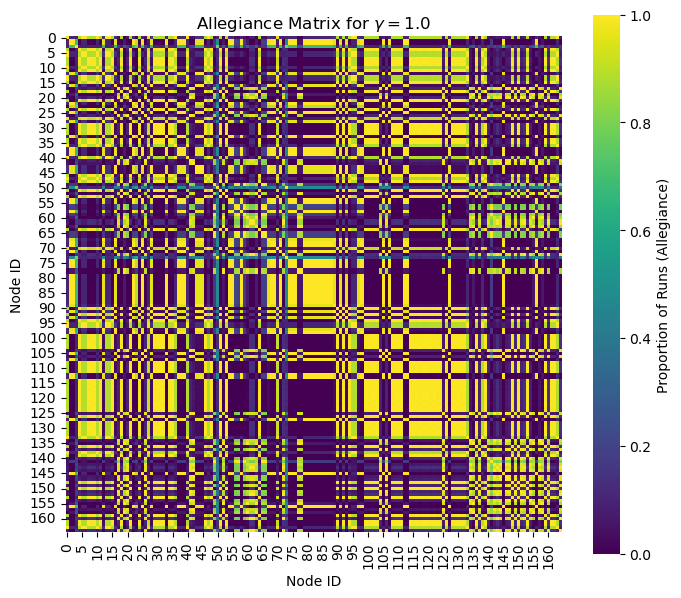

In [48]:
efferent_signed_results = build_allegiance_dict_signed(similarity_matrix=signed_efferent_connection_values)

Starting consensus clustering for 48 gamma values (100 runs each)...
  Finished gamma = 0.2
  Finished gamma = 0.3
  Finished gamma = 0.4
  Finished gamma = 0.5
  Finished gamma = 0.6
  Finished gamma = 0.7
  Finished gamma = 0.8
  Finished gamma = 0.9
  Finished gamma = 1.0
  Finished gamma = 1.1
  Finished gamma = 1.2
  Finished gamma = 1.3
  Finished gamma = 1.4
  Finished gamma = 1.5
  Finished gamma = 1.6
  Finished gamma = 1.7
  Finished gamma = 1.8
  Finished gamma = 1.9
  Finished gamma = 2.0
  Finished gamma = 2.1
  Finished gamma = 2.2
  Finished gamma = 2.3
  Finished gamma = 2.4
  Finished gamma = 2.5
  Finished gamma = 2.6
  Finished gamma = 2.7
  Finished gamma = 2.8
  Finished gamma = 2.9
  Finished gamma = 3.0
  Finished gamma = 3.1
  Finished gamma = 3.2
  Finished gamma = 3.3
  Finished gamma = 3.4
  Finished gamma = 3.5
  Finished gamma = 3.6
  Finished gamma = 3.7
  Finished gamma = 3.8
  Finished gamma = 3.9
  Finished gamma = 4.0
  Finished gamma = 4.1
  Finished 

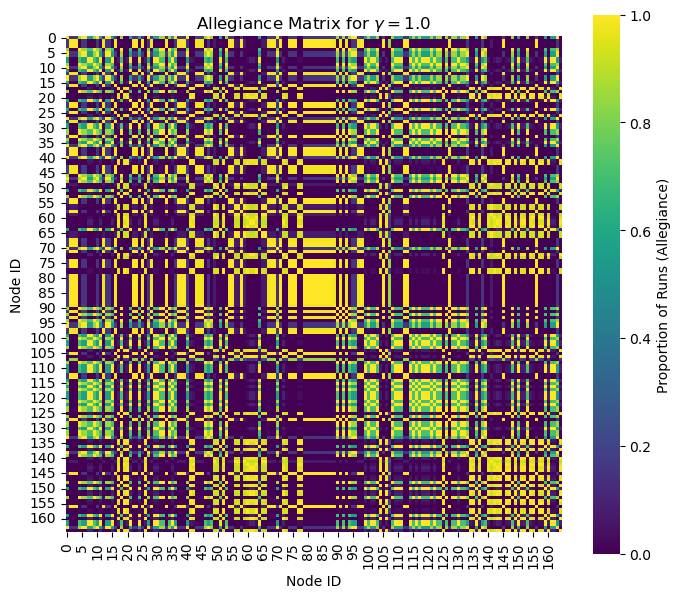

In [38]:

scores_allegiance = build_allegiance_dict(similarity_matrix = efferent_connection_values)

Starting consensus clustering for 48 gamma values (100 runs each)...
  Finished gamma = 0.2
  Finished gamma = 0.3
  Finished gamma = 0.4
  Finished gamma = 0.5
  Finished gamma = 0.6
  Finished gamma = 0.7
  Finished gamma = 0.8
  Finished gamma = 0.9
  Finished gamma = 1.0
  Finished gamma = 1.1
  Finished gamma = 1.2
  Finished gamma = 1.3
  Finished gamma = 1.4
  Finished gamma = 1.5
  Finished gamma = 1.6
  Finished gamma = 1.7
  Finished gamma = 1.8
  Finished gamma = 1.9
  Finished gamma = 2.0
  Finished gamma = 2.1
  Finished gamma = 2.2
  Finished gamma = 2.3
  Finished gamma = 2.4
  Finished gamma = 2.5
  Finished gamma = 2.6
  Finished gamma = 2.7
  Finished gamma = 2.8
  Finished gamma = 2.9
  Finished gamma = 3.0
  Finished gamma = 3.1
  Finished gamma = 3.2
  Finished gamma = 3.3
  Finished gamma = 3.4
  Finished gamma = 3.5
  Finished gamma = 3.6
  Finished gamma = 3.7
  Finished gamma = 3.8
  Finished gamma = 3.9
  Finished gamma = 4.0
  Finished gamma = 4.1
  Finished 

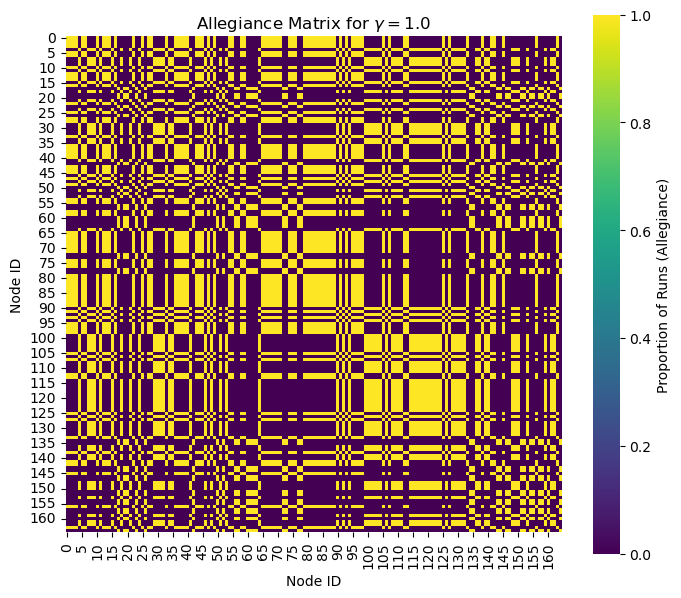

In [74]:
efferent_cosine_scores_allegiance = build_allegiance_dict_signed(
        similarity_matrix=cosine_from_values)

<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
/var/folders/4k/31jdbs595pn4tslnsm4nxmzm0000gq/T/ipykernel_97722/1831867016.py:13: SyntaxWarning: invalid escape sequence '\g'
  label=f'Peak Stability: $\gamma = {best_gamma:.1f}$ (NMI={best_score:.3f})')
/var/folders/4k/31jdbs595pn4tslnsm4nxmzm0000gq/T/ipykernel_97722/1831867016.py:14: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Gamma ($\gamma$) Resolution Parameter")


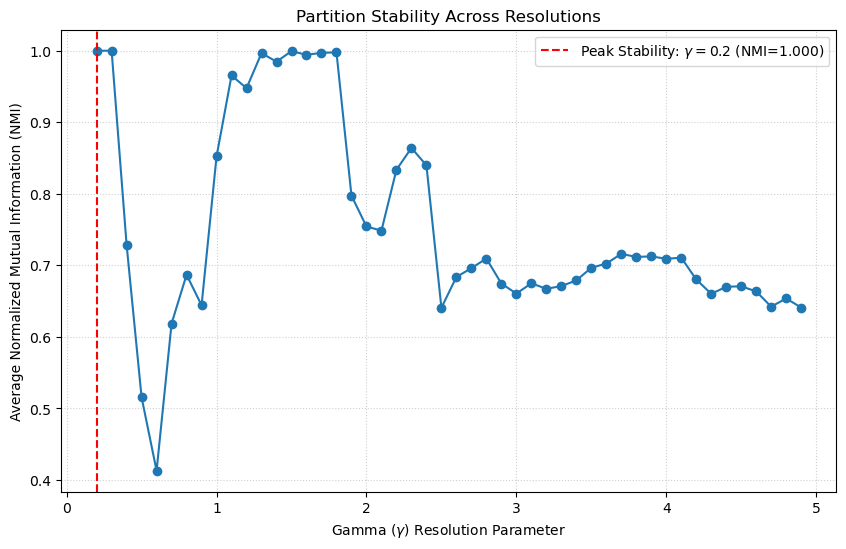

In [79]:
scores = efferent_cosine_scores_allegiance[0]
gammas = list(stability_scores.keys())
scores = list(stability_scores.values())

# Find the peak
best_gamma_index = np.argmax(scores)
best_gamma = gammas[best_gamma_index]
best_score = scores[best_gamma_index]

plt.figure(figsize=(10, 6))
plt.plot(gammas, scores, marker='o', linestyle='-')
plt.axvline(best_gamma, color='r', linestyle='--', 
            label=f'Peak Stability: $\gamma = {best_gamma:.1f}$ (NMI={best_score:.3f})')
plt.xlabel("Gamma ($\gamma$) Resolution Parameter")
plt.ylabel("Average Normalized Mutual Information (NMI)")
plt.title("Partition Stability Across Resolutions")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

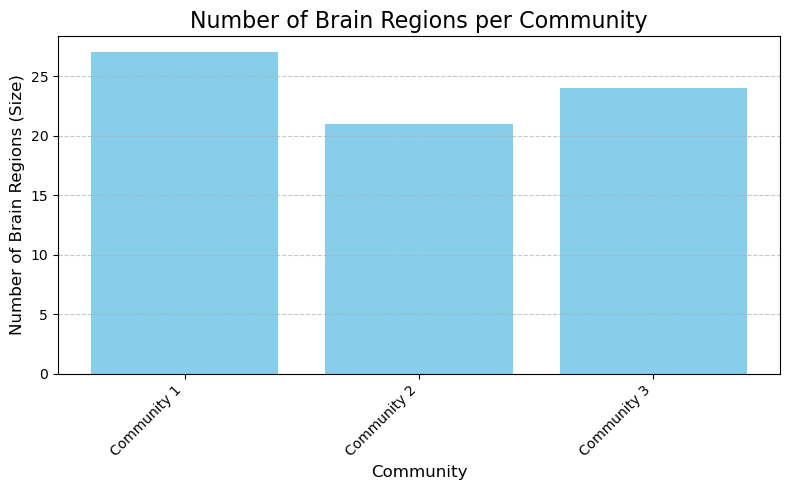

In [58]:
from helpers import plot_rsa, louvain_rsa
sorted_cosine_eff_shared, sorted_labels_eff_shared = louvain_rsa(similarity_matrix_values=cosine_from_shared_values,
                                                                 labels = cosine_from_shared_labels,
                                                                 gamma=1)

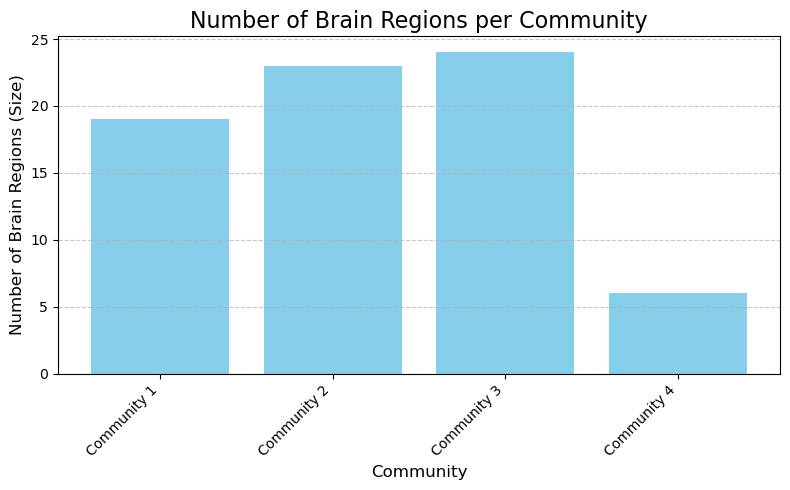

In [59]:
from helpers import plot_rsa, louvain_rsa
sorted_cosine_aff_shared, sorted_labels_aff_shared = louvain_rsa(similarity_matrix_values=cosine_to_shared_values,
                                                                 labels = cosine_to_shared_labels,
                                                                 gamma=1)

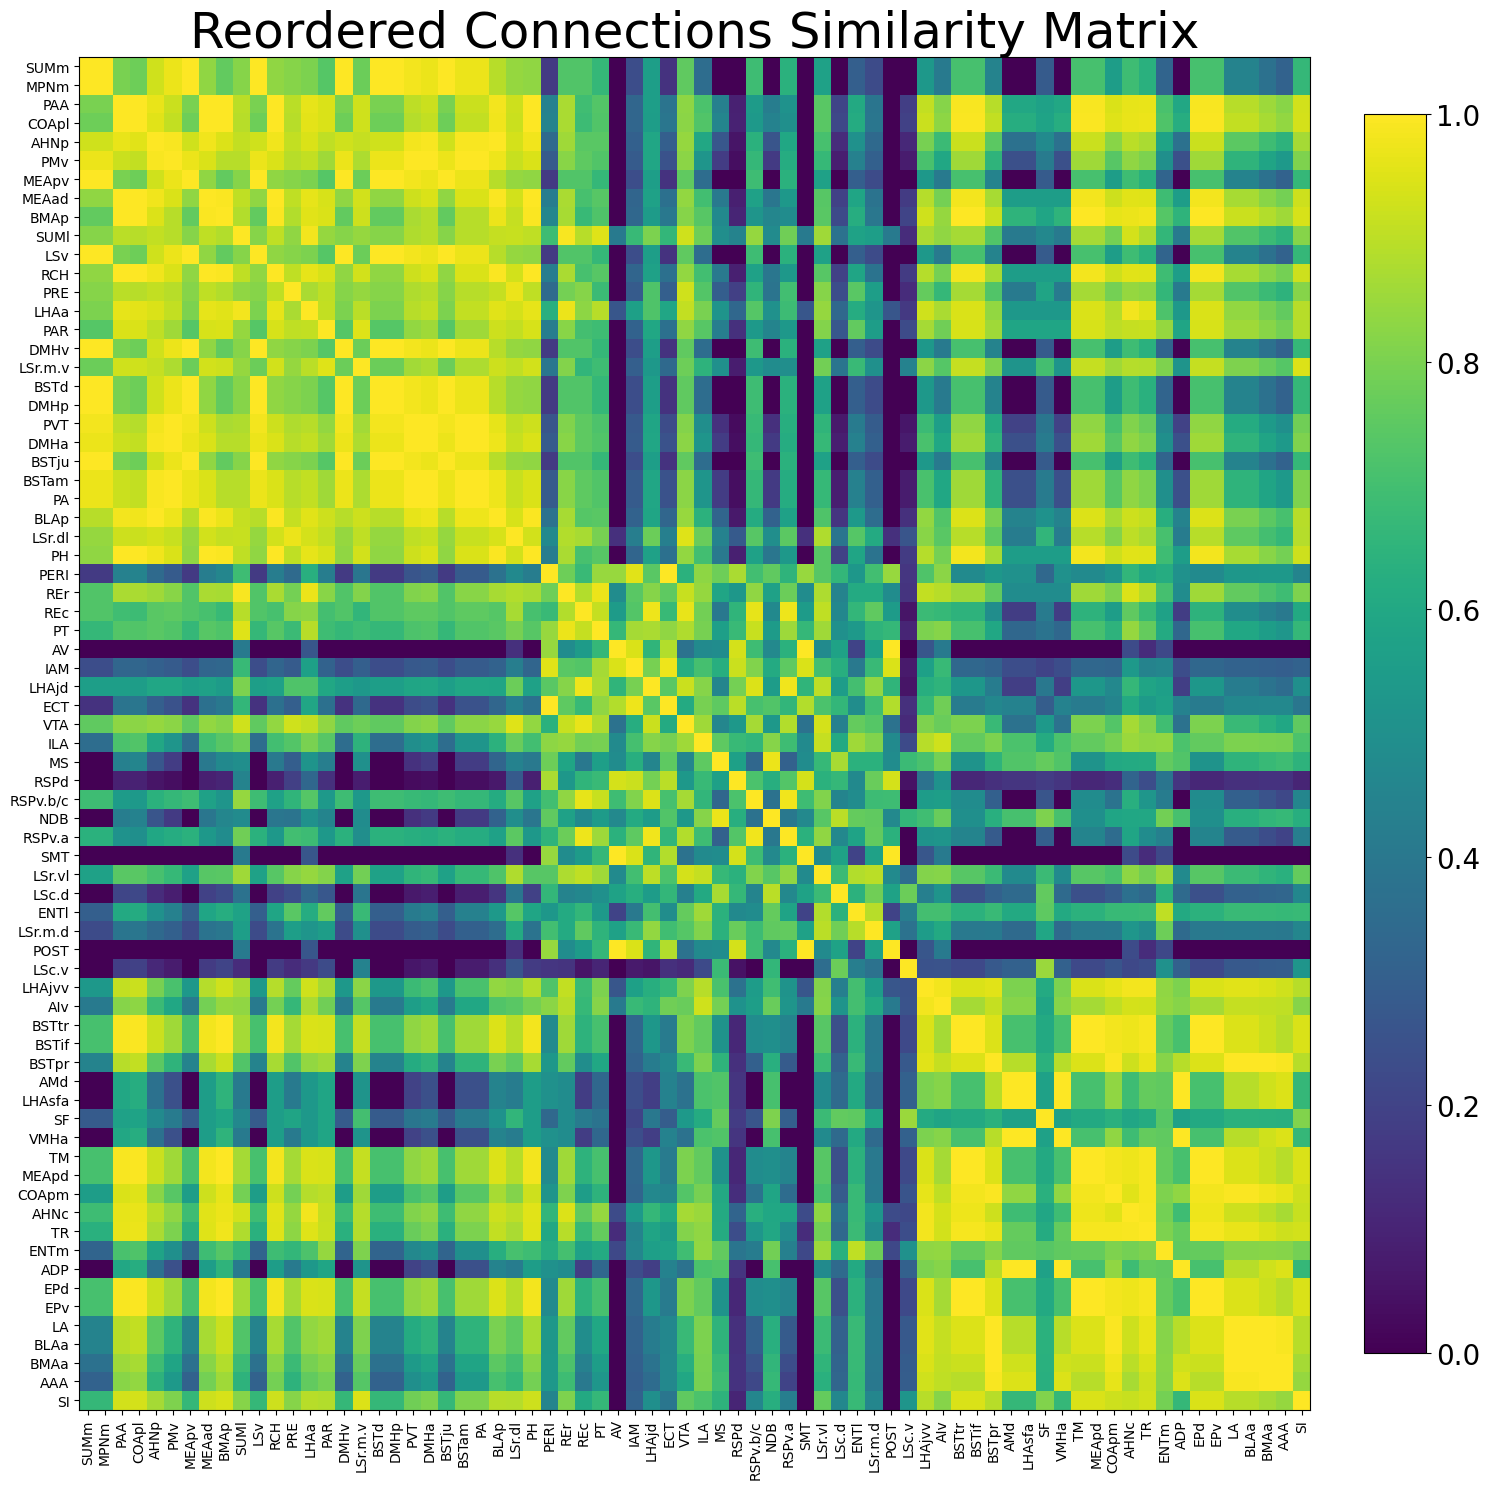

In [60]:
plot_rsa(sorted_cosine_eff_shared, sorted_labels_eff_shared)

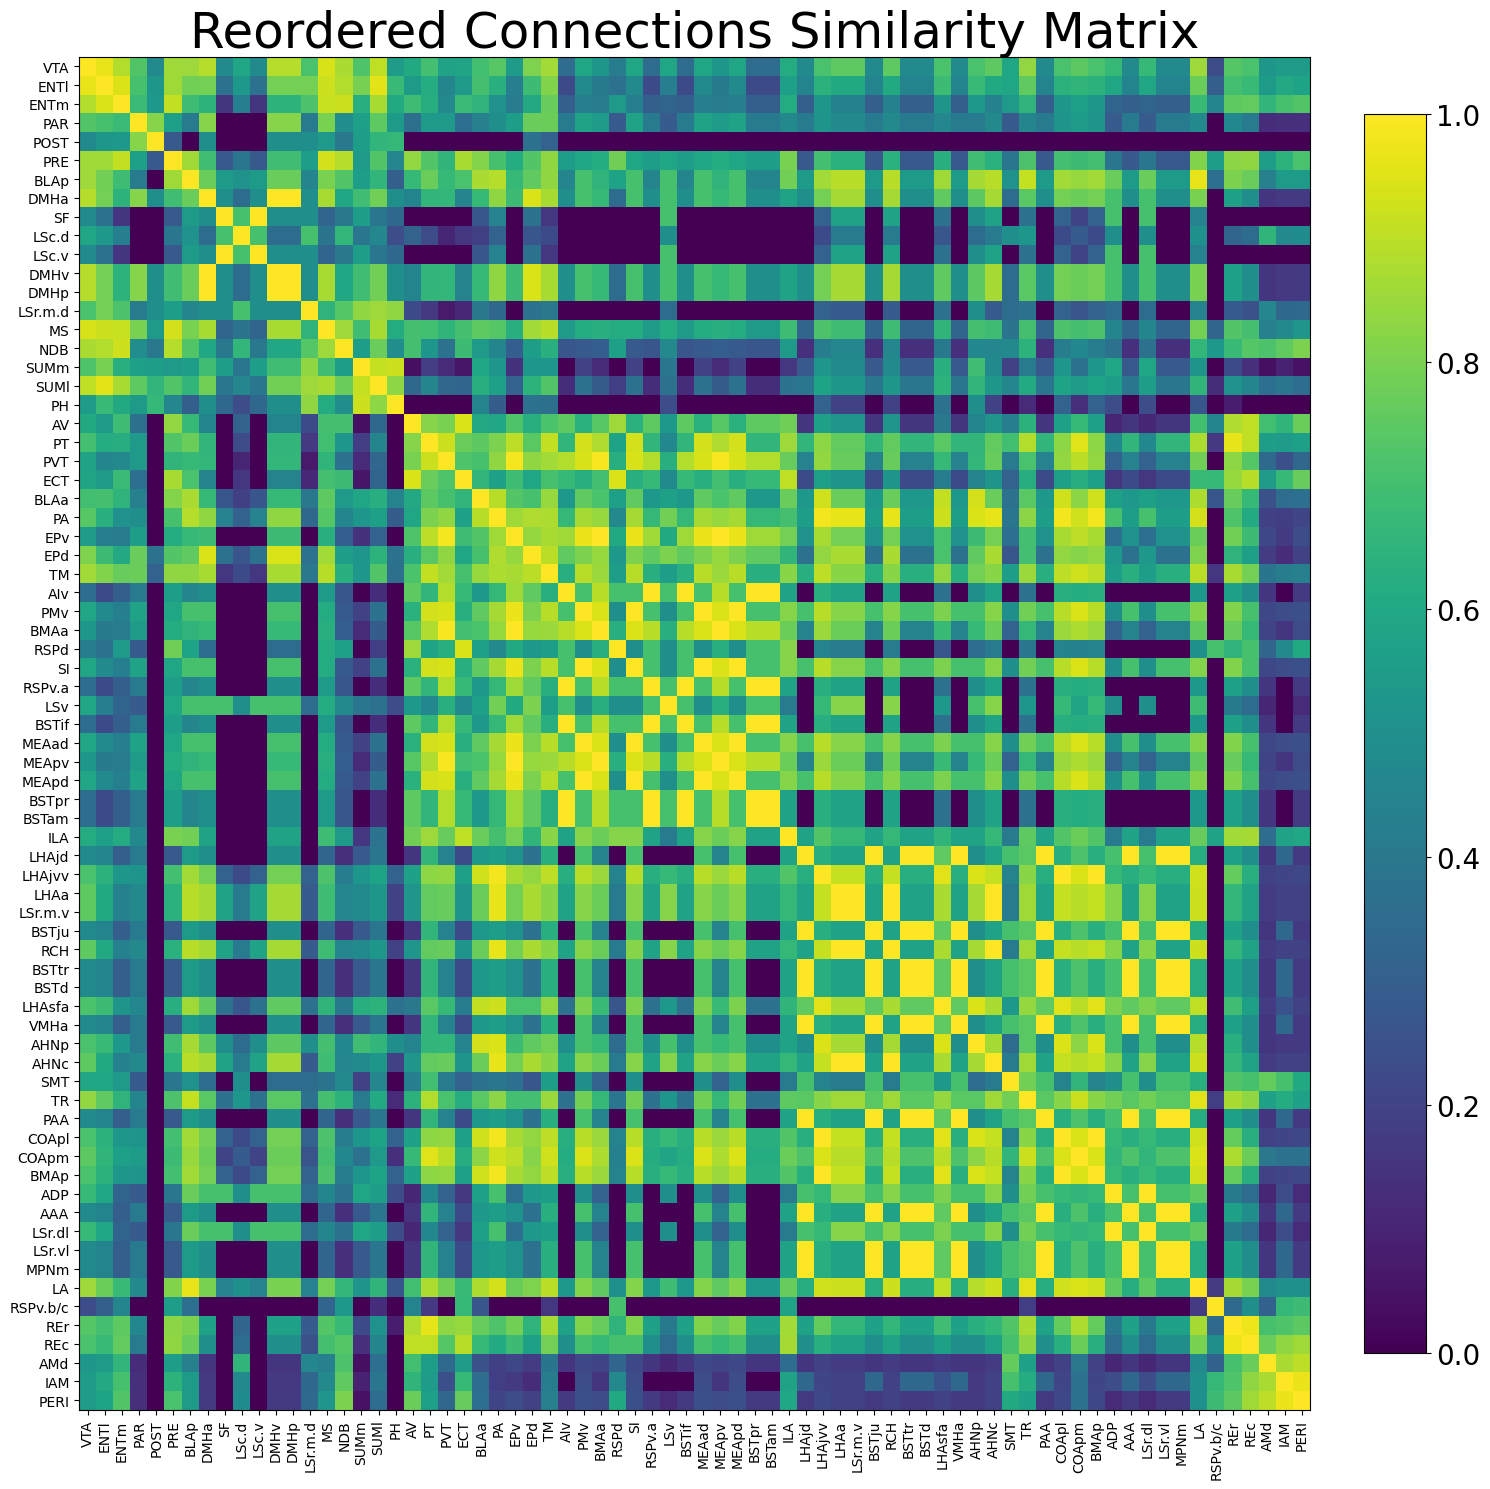

In [61]:
plot_rsa(sorted_cosine_aff_shared, sorted_labels_aff_shared)

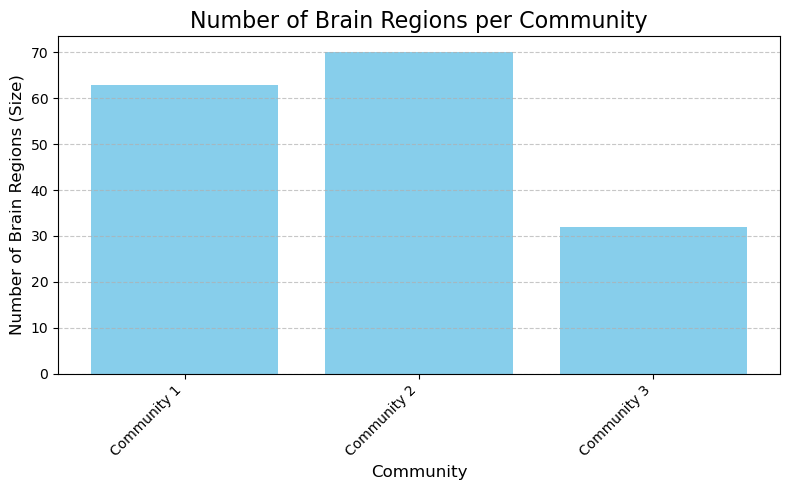

In [22]:
from helpers import plot_rsa, louvain_rsa
sorted_cosine_eff, sorted_labels_eff = louvain_rsa(similarity_matrix_values=cosine_from_values,
                                           labels = cosine_from_labels,
                                           gamma=1)

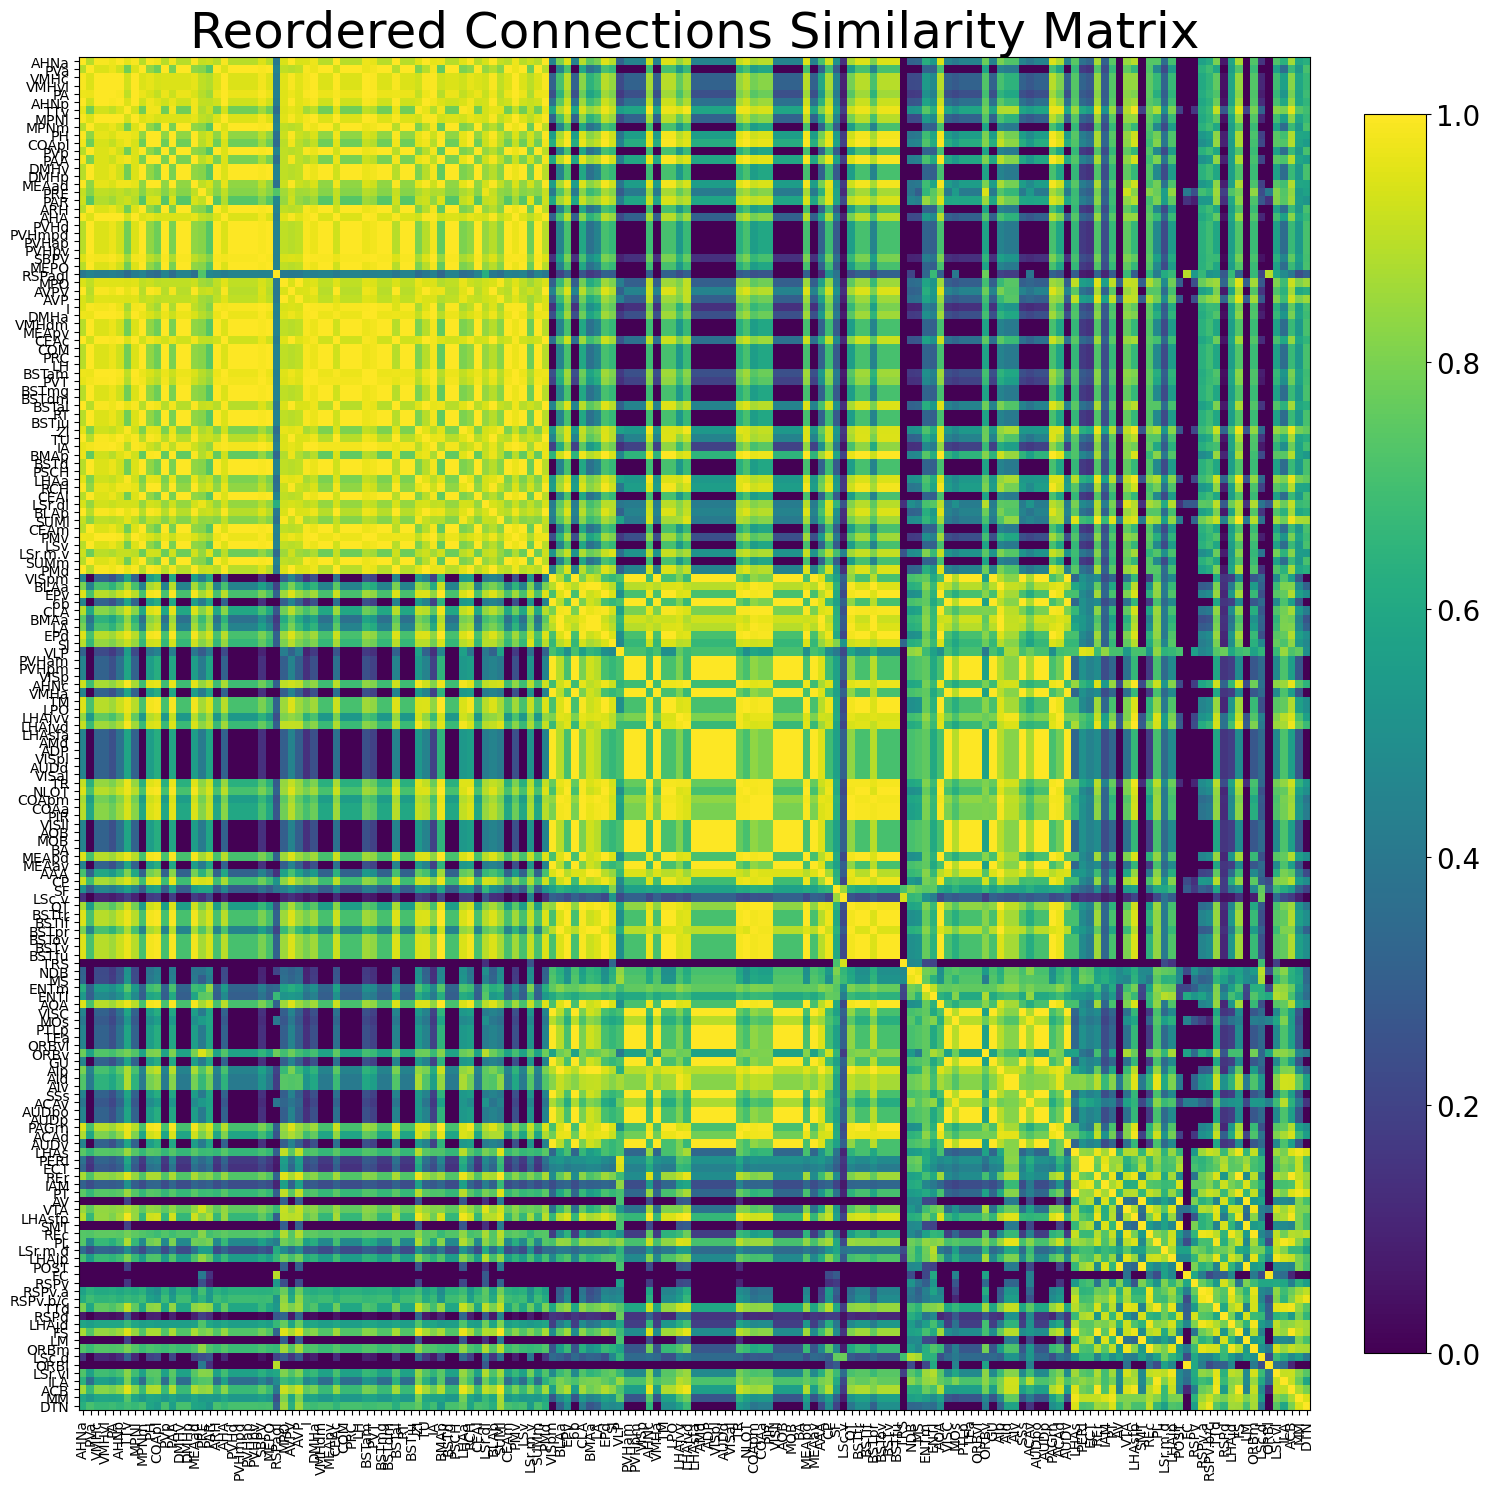

In [23]:
plot_rsa(sorted_cosine_eff, sorted_labels_eff)

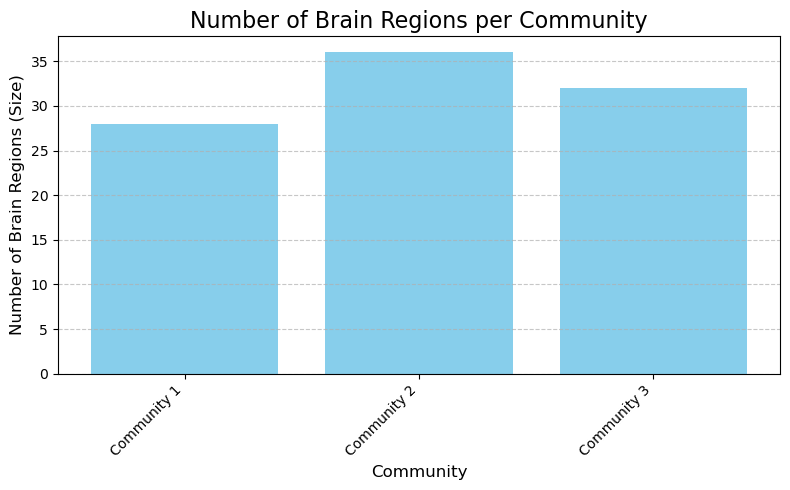

In [50]:
from helpers import plot_rsa, louvain_rsa
sorted_cosine_aff, sorted_labels_aff = louvain_rsa(similarity_matrix_values=cosine_to_values,
                                           labels = cosine_to_labels,
                                           gamma=1)

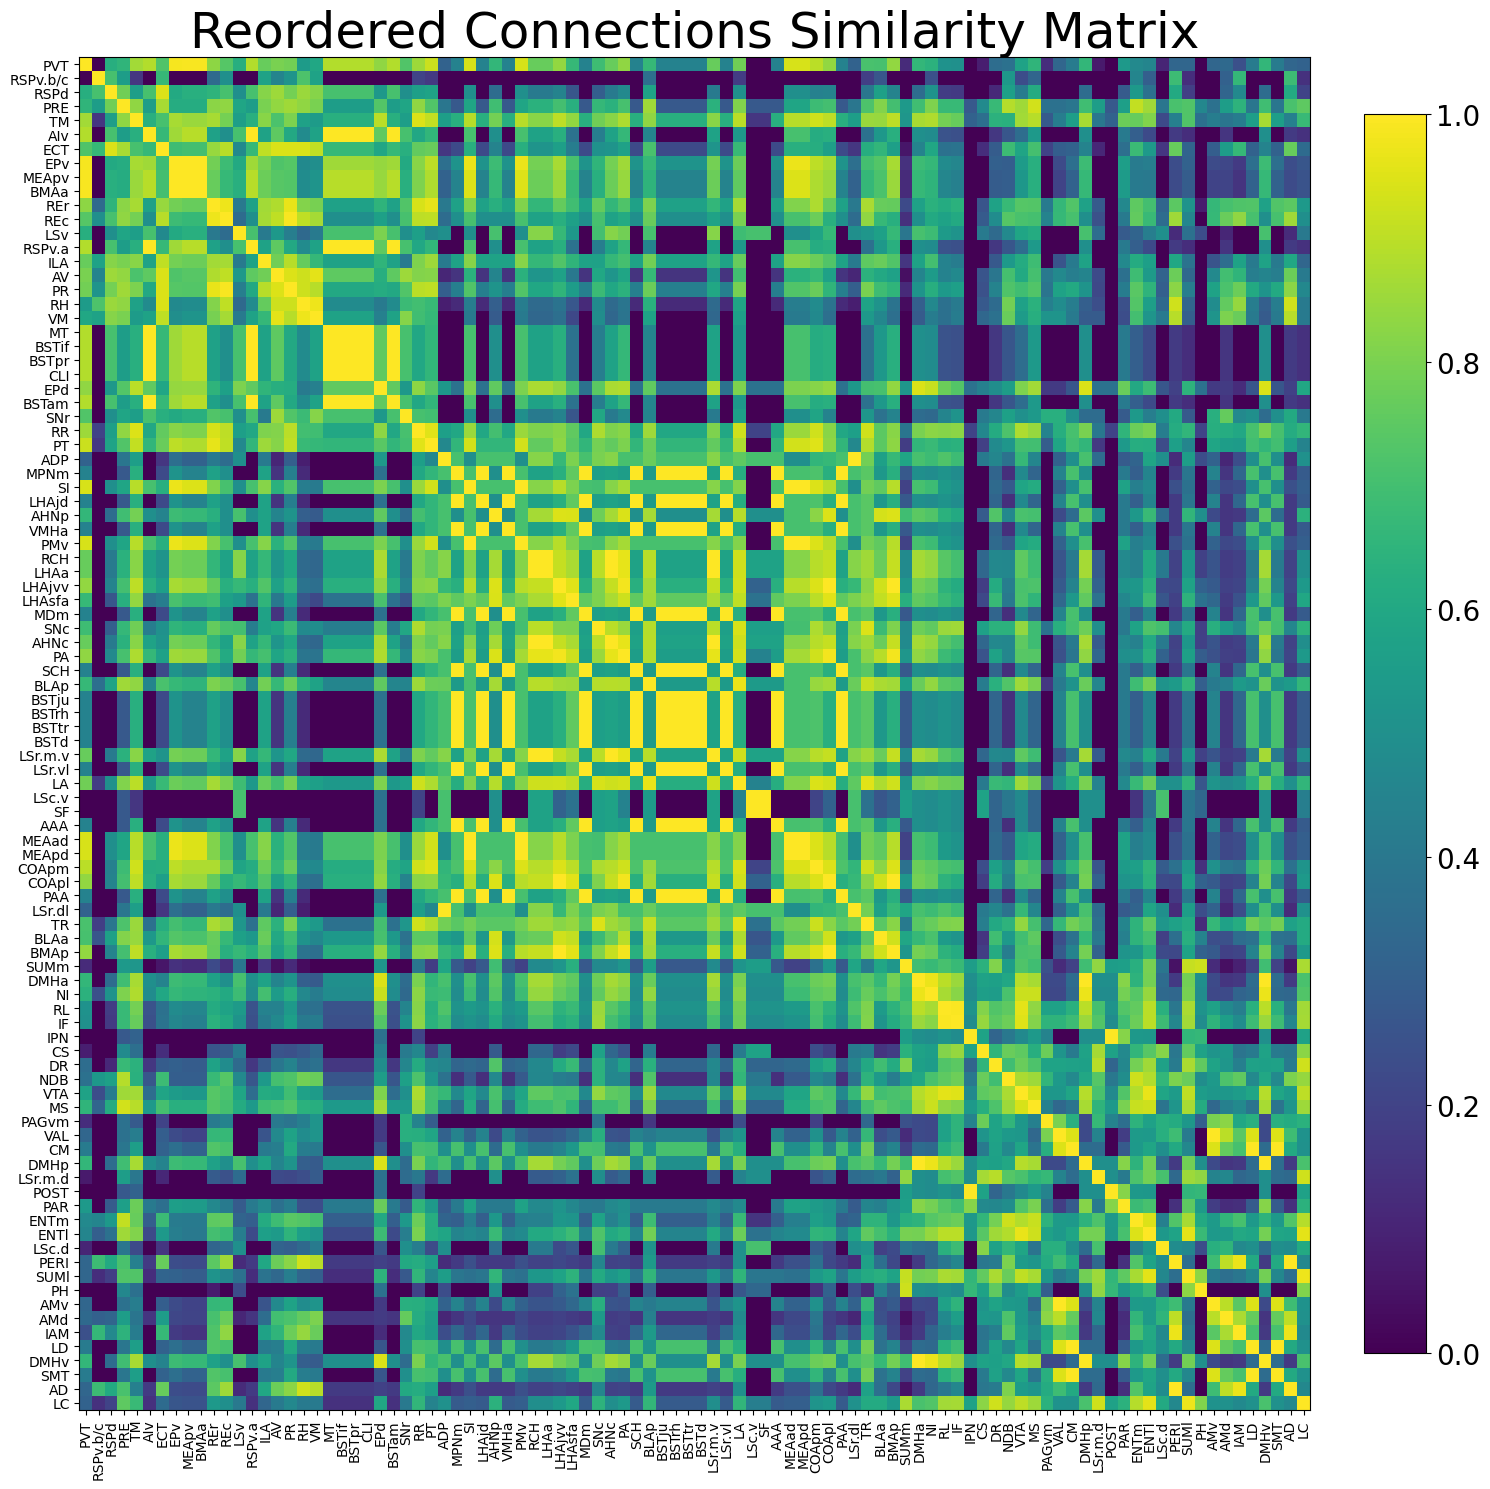

In [51]:
plot_rsa(sorted_cosine_aff, sorted_labels_aff)

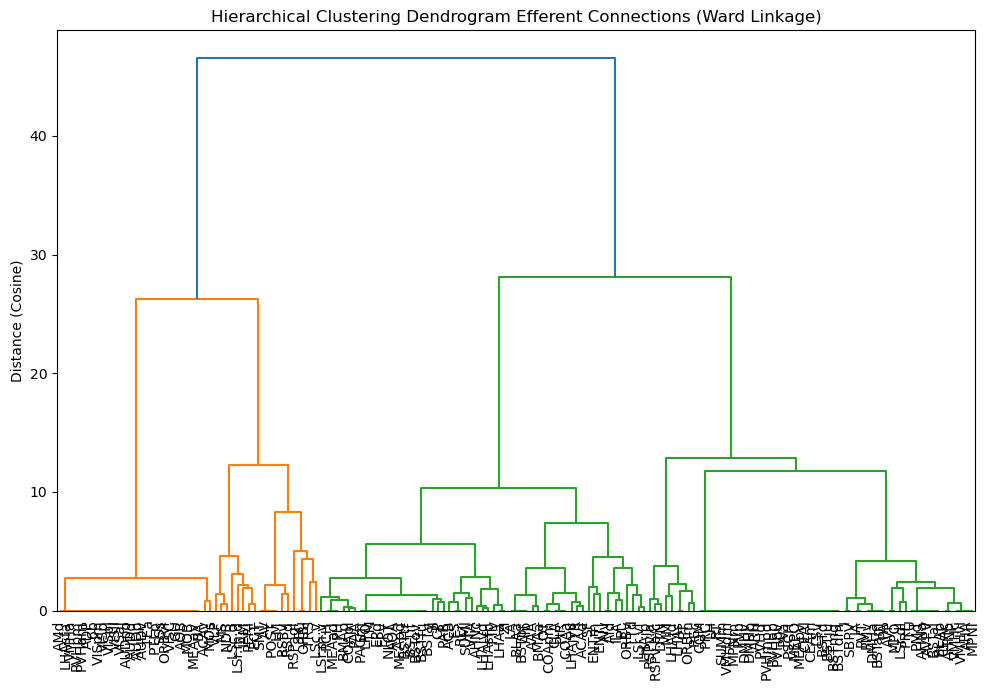

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

cosine_distance_values = 1 - cosine_from_values

# --- 3. Perform Hierarchical Clustering (Linkage) ---
# The `linkage` function performs the actual clustering.
#
# 'method='ward'' is a very popular and robust method. It minimizes
# the variance within each cluster. Other options include 'complete',
# 'average', and 'single'.
#
# Z is the "linkage matrix" that encodes the cluster hierarchy.
Z = linkage(cosine_distance_values, method='ward')

# --- 4. Plot the Dendrogram ---
# This is the best part of hierarchical clustering! The dendrogram
# visualizes the entire hierarchy of how regions are grouped.
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram Efferent Connections (Ward Linkage)")
plt.ylabel("Distance (Cosine)")

dendrogram(
    Z,
    labels=cosine_from_labels,
    leaf_rotation=90,  # Rotates the x-axis labels
    leaf_font_size=10  # Sets the font size
)

plt.tight_layout()
plt.show()

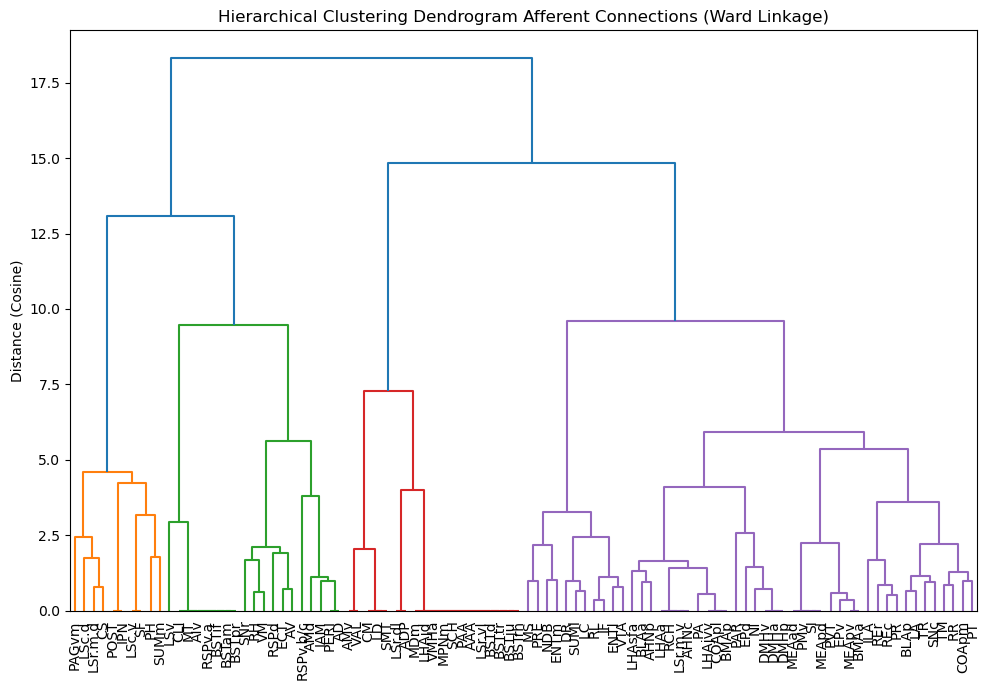

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

cosine_distance_values = 1 - cosine_to_values

# --- 3. Perform Hierarchical Clustering (Linkage) ---
# The `linkage` function performs the actual clustering.
#
# 'method='ward'' is a very popular and robust method. It minimizes
# the variance within each cluster. Other options include 'complete',
# 'average', and 'single'.
#
# Z is the "linkage matrix" that encodes the cluster hierarchy.
Z_afferent = linkage(cosine_distance_values, method='ward')

# --- 4. Plot the Dendrogram ---
# This is the best part of hierarchical clustering! The dendrogram
# visualizes the entire hierarchy of how regions are grouped.
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram Afferent Connections (Ward Linkage)")
plt.ylabel("Distance (Cosine)")

dendrogram(
    Z_afferent,
    labels=cosine_to_labels,
    leaf_rotation=90,  # Rotates the x-axis labels
    leaf_font_size=10  # Sets the font size
)

plt.tight_layout()
plt.show()

Calculating Silhouette scores...
k = 2, Silhouette Score = 0.5465
k = 3, Silhouette Score = 0.3996
k = 4, Silhouette Score = 0.5288
k = 5, Silhouette Score = 0.5327
k = 6, Silhouette Score = 0.5472
k = 7, Silhouette Score = 0.4525
k = 8, Silhouette Score = 0.4662
k = 9, Silhouette Score = 0.5054
k = 10, Silhouette Score = 0.5170
k = 11, Silhouette Score = 0.5704
k = 12, Silhouette Score = 0.5589
k = 13, Silhouette Score = 0.5546
k = 14, Silhouette Score = 0.5650
k = 15, Silhouette Score = 0.5985
k = 16, Silhouette Score = 0.5920
k = 17, Silhouette Score = 0.5708
k = 18, Silhouette Score = 0.5765
k = 19, Silhouette Score = 0.5450
k = 20, Silhouette Score = 0.5442
k = 21, Silhouette Score = 0.5446
k = 22, Silhouette Score = 0.5373
k = 23, Silhouette Score = 0.5573
k = 24, Silhouette Score = 0.5465
k = 25, Silhouette Score = 0.5942
k = 26, Silhouette Score = 0.5898
k = 27, Silhouette Score = 0.5944
k = 28, Silhouette Score = 0.5937
k = 29, Silhouette Score = 0.6047
k = 30, Silhouette Scor

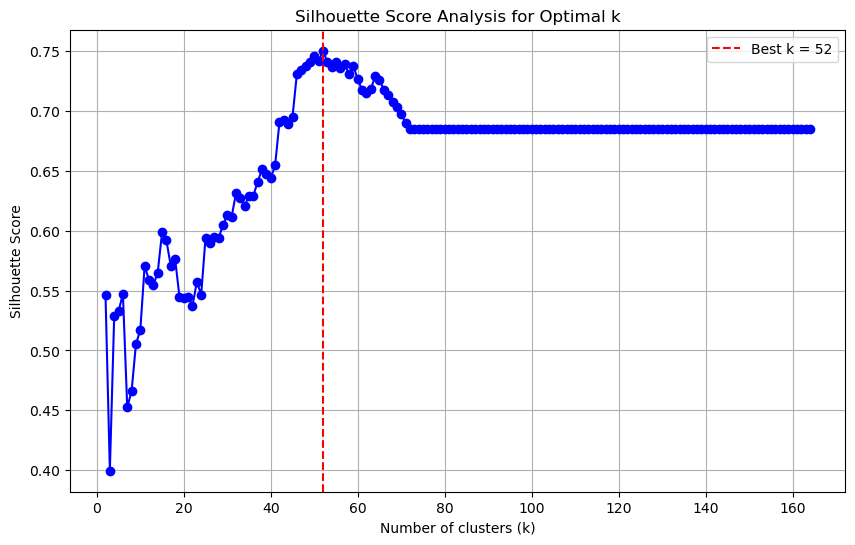

In [47]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score


num_regions = len(df_avg_from.T)
# --- 3. Silhouette Score Analysis ---

# We need to test a range of possible cluster numbers (k).
# We can't have 1 cluster (silhouette score is undefined).
# We can't have num_regions clusters (also undefined).
# So, k_range is from 2 to num_regions - 1.
k_range = range(2, num_regions)
silhouette_scores = []

print("Calculating Silhouette scores...")

for k in k_range:
    # 1. Get the flat cluster labels for this 'k'
    # 'criterion='maxclust'' means "find k clusters"
    labels = fcluster(Z, t=k, criterion='maxclust')
    
    # 2. Calculate the silhouette score
    # We pass the original data 'X' and the 'labels' we just found.
    # It's important to use the same metric ('cosine') that you
    # used for clustering.
    score = silhouette_score(df_avg_from.T, labels, metric='cosine')
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.4f}")

# Find the k with the highest score
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"\nBest k: {best_k} (with a score of {best_score:.4f})")

# --- 4. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-') # 'bo-' = blue dots with a line
plt.title("Silhouette Score Analysis for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")

# Highlight the best k
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.legend()
plt.grid(True)
plt.savefig("silhouette_score_plot.png")

Calculating Silhouette scores...
k = 2, Silhouette Score = 0.3190
k = 3, Silhouette Score = 0.2884
k = 4, Silhouette Score = 0.3532
k = 5, Silhouette Score = 0.3074
k = 6, Silhouette Score = 0.3490
k = 7, Silhouette Score = 0.3925
k = 8, Silhouette Score = 0.3779
k = 9, Silhouette Score = 0.3807
k = 10, Silhouette Score = 0.4107
k = 11, Silhouette Score = 0.4268
k = 12, Silhouette Score = 0.4533
k = 13, Silhouette Score = 0.4873
k = 14, Silhouette Score = 0.5086
k = 15, Silhouette Score = 0.5159
k = 16, Silhouette Score = 0.5273
k = 17, Silhouette Score = 0.5325
k = 18, Silhouette Score = 0.5701
k = 19, Silhouette Score = 0.5819
k = 20, Silhouette Score = 0.5873
k = 21, Silhouette Score = 0.5922
k = 22, Silhouette Score = 0.5948
k = 23, Silhouette Score = 0.5964
k = 24, Silhouette Score = 0.6093
k = 25, Silhouette Score = 0.6071
k = 26, Silhouette Score = 0.6051
k = 27, Silhouette Score = 0.6073
k = 28, Silhouette Score = 0.5864
k = 29, Silhouette Score = 0.5737
k = 30, Silhouette Scor

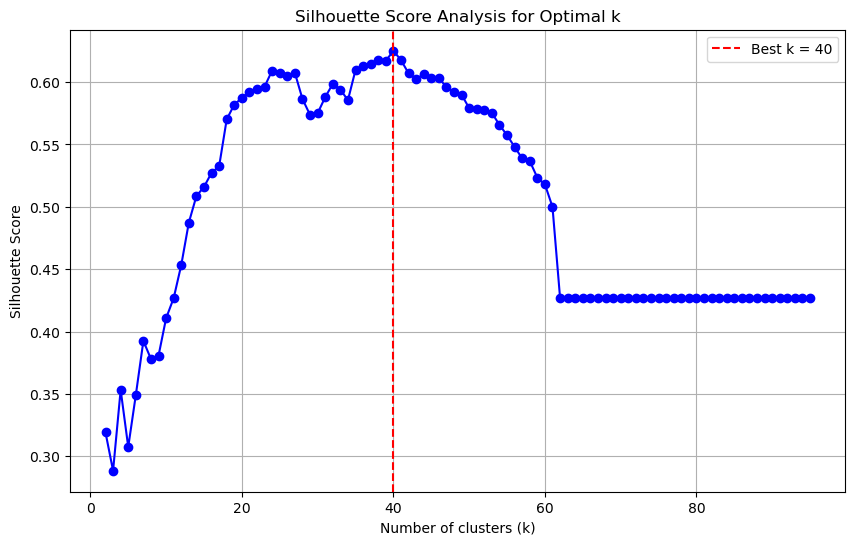

In [49]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score


num_regions = len(df_avg_to.T)
Z_afferent = linkage(cosine_to_values, method='ward')
# --- 3. Silhouette Score Analysis ---

# We need to test a range of possible cluster numbers (k).
# We can't have 1 cluster (silhouette score is undefined).
# We can't have num_regions clusters (also undefined).
# So, k_range is from 2 to num_regions - 1.
k_range = range(2, num_regions)
silhouette_scores = []

print("Calculating Silhouette scores...")

for k in k_range:
    # 1. Get the flat cluster labels for this 'k'
    # 'criterion='maxclust'' means "find k clusters"
    labels = fcluster(Z_afferent, t=k, criterion='maxclust')
    
    # 2. Calculate the silhouette score
    # We pass the original data 'X' and the 'labels' we just found.
    # It's important to use the same metric ('cosine') that you
    # used for clustering.
    score = silhouette_score(df_avg_to.T, labels, metric='cosine')
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.4f}")

# Find the k with the highest score
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"\nBest k: {best_k} (with a score of {best_score:.4f})")

# --- 4. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-') # 'bo-' = blue dots with a line
plt.title("Silhouette Score Analysis for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")

# Highlight the best k
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.legend()
plt.grid(True)
plt.savefig("silhouette_score_plot.png")